In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib import pyplot as plt

In [2]:
##Load in Train Set
X_train_path = "../../data/preprocessed_data/training/X_train_enc.parquet"
X_train = pd.read_parquet(X_train_path)
y_train_path = "../../data/preprocessed_data/training/y_train.parquet"
y_train = pd.read_parquet(y_train_path)
y_train = pd.DataFrame(y_train['label'].astype(int))

## Load in Test Set
X_test_path = "../../data/preprocessed_data/test/X_test_enc.parquet"
X_test = pd.read_parquet(X_test_path)

y_test_path = "../../data/preprocessed_data/test/y_test.parquet"
y_test = pd.read_parquet(y_test_path)
y_test = pd.DataFrame(y_test['label'].astype(int)) ## convert labels to int for roc auc calculation

## Load in Validation Set
X_val_path = "../../data/preprocessed_data/validation/X_val_enc.parquet"
X_val = pd.read_parquet(X_val_path)

y_val_path = "../../data/preprocessed_data/validation/y_val.parquet"
y_val = pd.read_parquet(y_val_path)
y_val = pd.DataFrame(y_val['label'].astype(int))


In [3]:
# Combing all into one X_data and Y_data to do
X_frames = [X_train, X_test, X_val]
y_frames = [y_train, y_test, y_val]

X_data = pd.concat(X_frames)
y_data = pd.concat(y_frames)

data = X_data.copy()
data['label'] = y_data

In [4]:
data.shape

(54374, 73)

In [5]:
data.head()

,reads_count,dwelling_time_-1_25,dwelling_time_-1_50,dwelling_time_-1_75,dwelling_time_-1_mean,dwelling_time_-1_min,dwelling_time_-1_max,std_-1_25,std_-1_50,std_-1_75,...,position_2_A,position_2_G,position_5_C,position_5_A,position_5_T,position_6_T,position_6_A,position_6_G,position_6_C,label
0,-0.429603,-0.097196,-0.491042,-0.681852,-0.757836,0.023085,-1.355167,-0.625580,-0.777883,-0.816721,...,1,0,1,0,0,1,0,0,0,0
1,-0.350251,-0.667241,-0.836892,-0.576006,-0.738994,0.023085,-0.981329,-0.912831,-0.745608,-0.591965,...,0,1,1,0,0,1,0,0,0,0
2,-0.494527,-1.646377,-1.552442,-1.727199,-1.942534,0.023085,-1.577449,-1.089840,-0.969047,-0.850329,...,1,0,0,1,0,0,1,0,0,0
3,-0.335823,-0.162025,-0.562597,-0.773584,-0.674330,1.436755,0.362466,-0.422175,-0.452655,-0.560457,...,0,1,0,1,0,1,0,0,0,0
4,-0.494527,-1.498836,-1.170815,-1.628410,-1.661636,-0.673200,-1.183403,-1.217162,-0.929325,-0.953254,...,1,0,0,0,1,1,0,0,0,0


In [6]:
len(data.columns)

73

In [7]:
num_data = data[['reads_count', 'dwelling_time_-1_25', 'dwelling_time_-1_50',
                'dwelling_time_-1_75', 'dwelling_time_-1_mean', 'dwelling_time_-1_min',
                'dwelling_time_-1_max', 'std_-1_25', 'std_-1_50', 'std_-1_75',
                'std_-1_mean', 'std_-1_min', 'std_-1_max', 'mean_-1_25', 'mean_-1_50',
                'mean_-1_75', 'mean_-1_mean', 'mean_-1_min', 'mean_-1_max',
                'dwelling_time_0_25', 'dwelling_time_0_50', 'dwelling_time_0_75',
                'dwelling_time_0_mean', 'dwelling_time_0_min', 'dwelling_time_0_max',
                'std_0_25', 'std_0_50', 'std_0_75', 'std_0_mean', 'std_0_min',
                'std_0_max', 'mean_0_25', 'mean_0_50', 'mean_0_75', 'mean_0_mean',
                'mean_0_min', 'mean_0_max', 'dwelling_time_+1_25',
                'dwelling_time_+1_50', 'dwelling_time_+1_75', 'dwelling_time_+1_mean',
                'dwelling_time_+1_min', 'dwelling_time_+1_max', 'std_+1_25',
                'std_+1_50', 'std_+1_75', 'std_+1_mean', 'std_+1_min', 'std_+1_max',
                'mean_+1_25', 'mean_+1_50', 'mean_+1_75', 'mean_+1_mean', 'mean_+1_min',
                'mean_+1_max', 'relative_position']]

cat_data = data[['position_0_C', 'position_0_G',
                'position_0_T', 'position_0_A', 'position_1_A', 'position_1_G',
                'position_1_T', 'position_2_A', 'position_2_G', 'position_5_C',
                'position_5_A', 'position_5_T', 'position_6_T', 'position_6_A',
                'position_6_G', 'position_6_C', 'label']]

In [8]:
len(num_data.columns) + len(cat_data.columns)

73

# Relationships between Categorical Variables

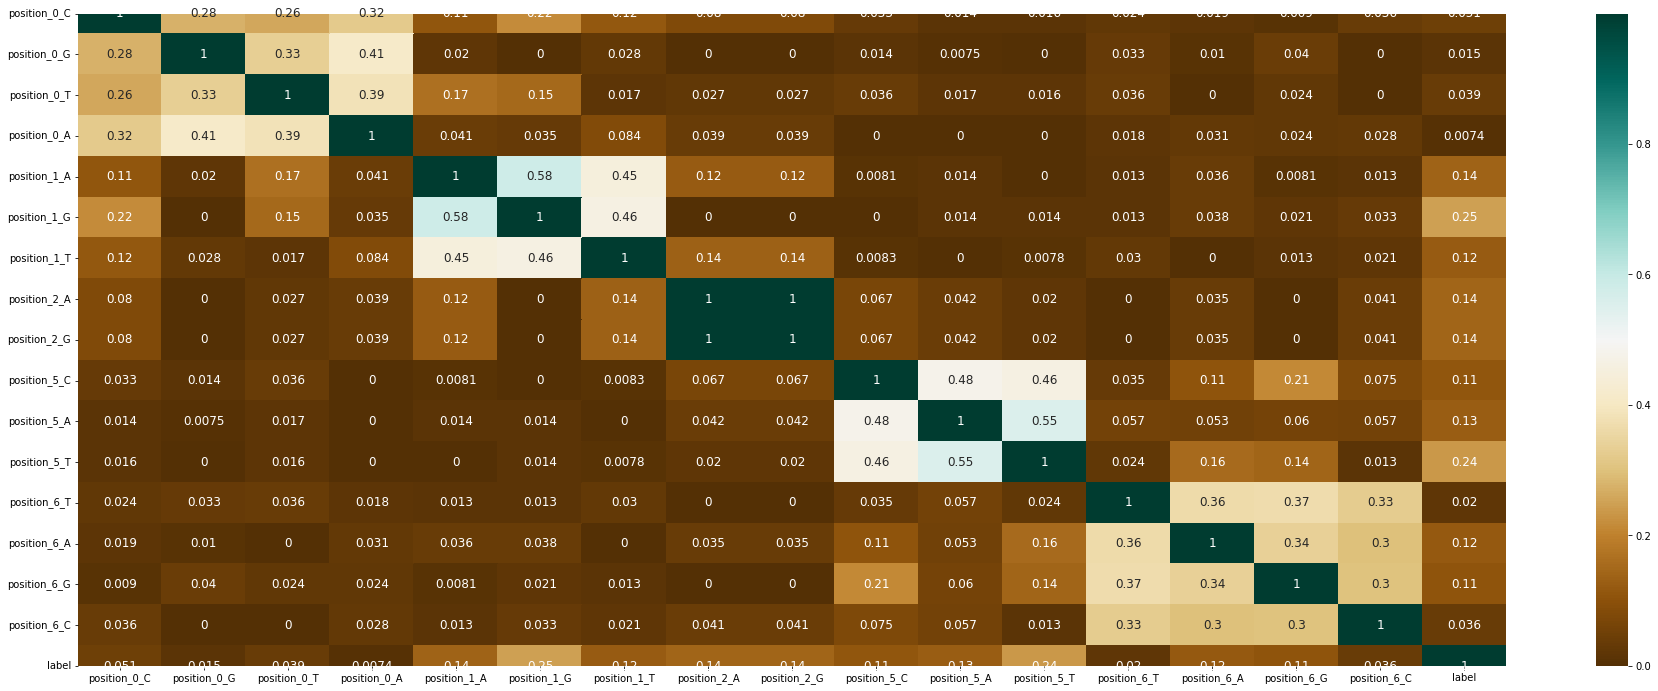

In [11]:
##  CRAMER V source: https://www.statology.org/cramers-v-in-python/

def cramers_corrected_stat(column1, column2):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(cat_data[column1],cat_data[column2])
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    p = ss.chi2_contingency(confusion_matrix)[1]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    final = np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    if p > 0.05:
        final = 0
    return final


result_df = pd.DataFrame(columns = cat_data.columns, index = cat_data.columns)

for col1 in cat_data:
    for col2 in cat_data:
        result_df[col1][col2] = cramers_corrected_stat(col1,col2)

plt.figure(figsize=(32,12))
result_df = result_df.apply(pd.to_numeric)
cramers_heatmap = sns.heatmap(result_df, annot=True, annot_kws={"size": 12}, cmap='BrBG')

# Relationships Between Numerical Variables

Text(0.5, 1, 'Correlation Heatmap')

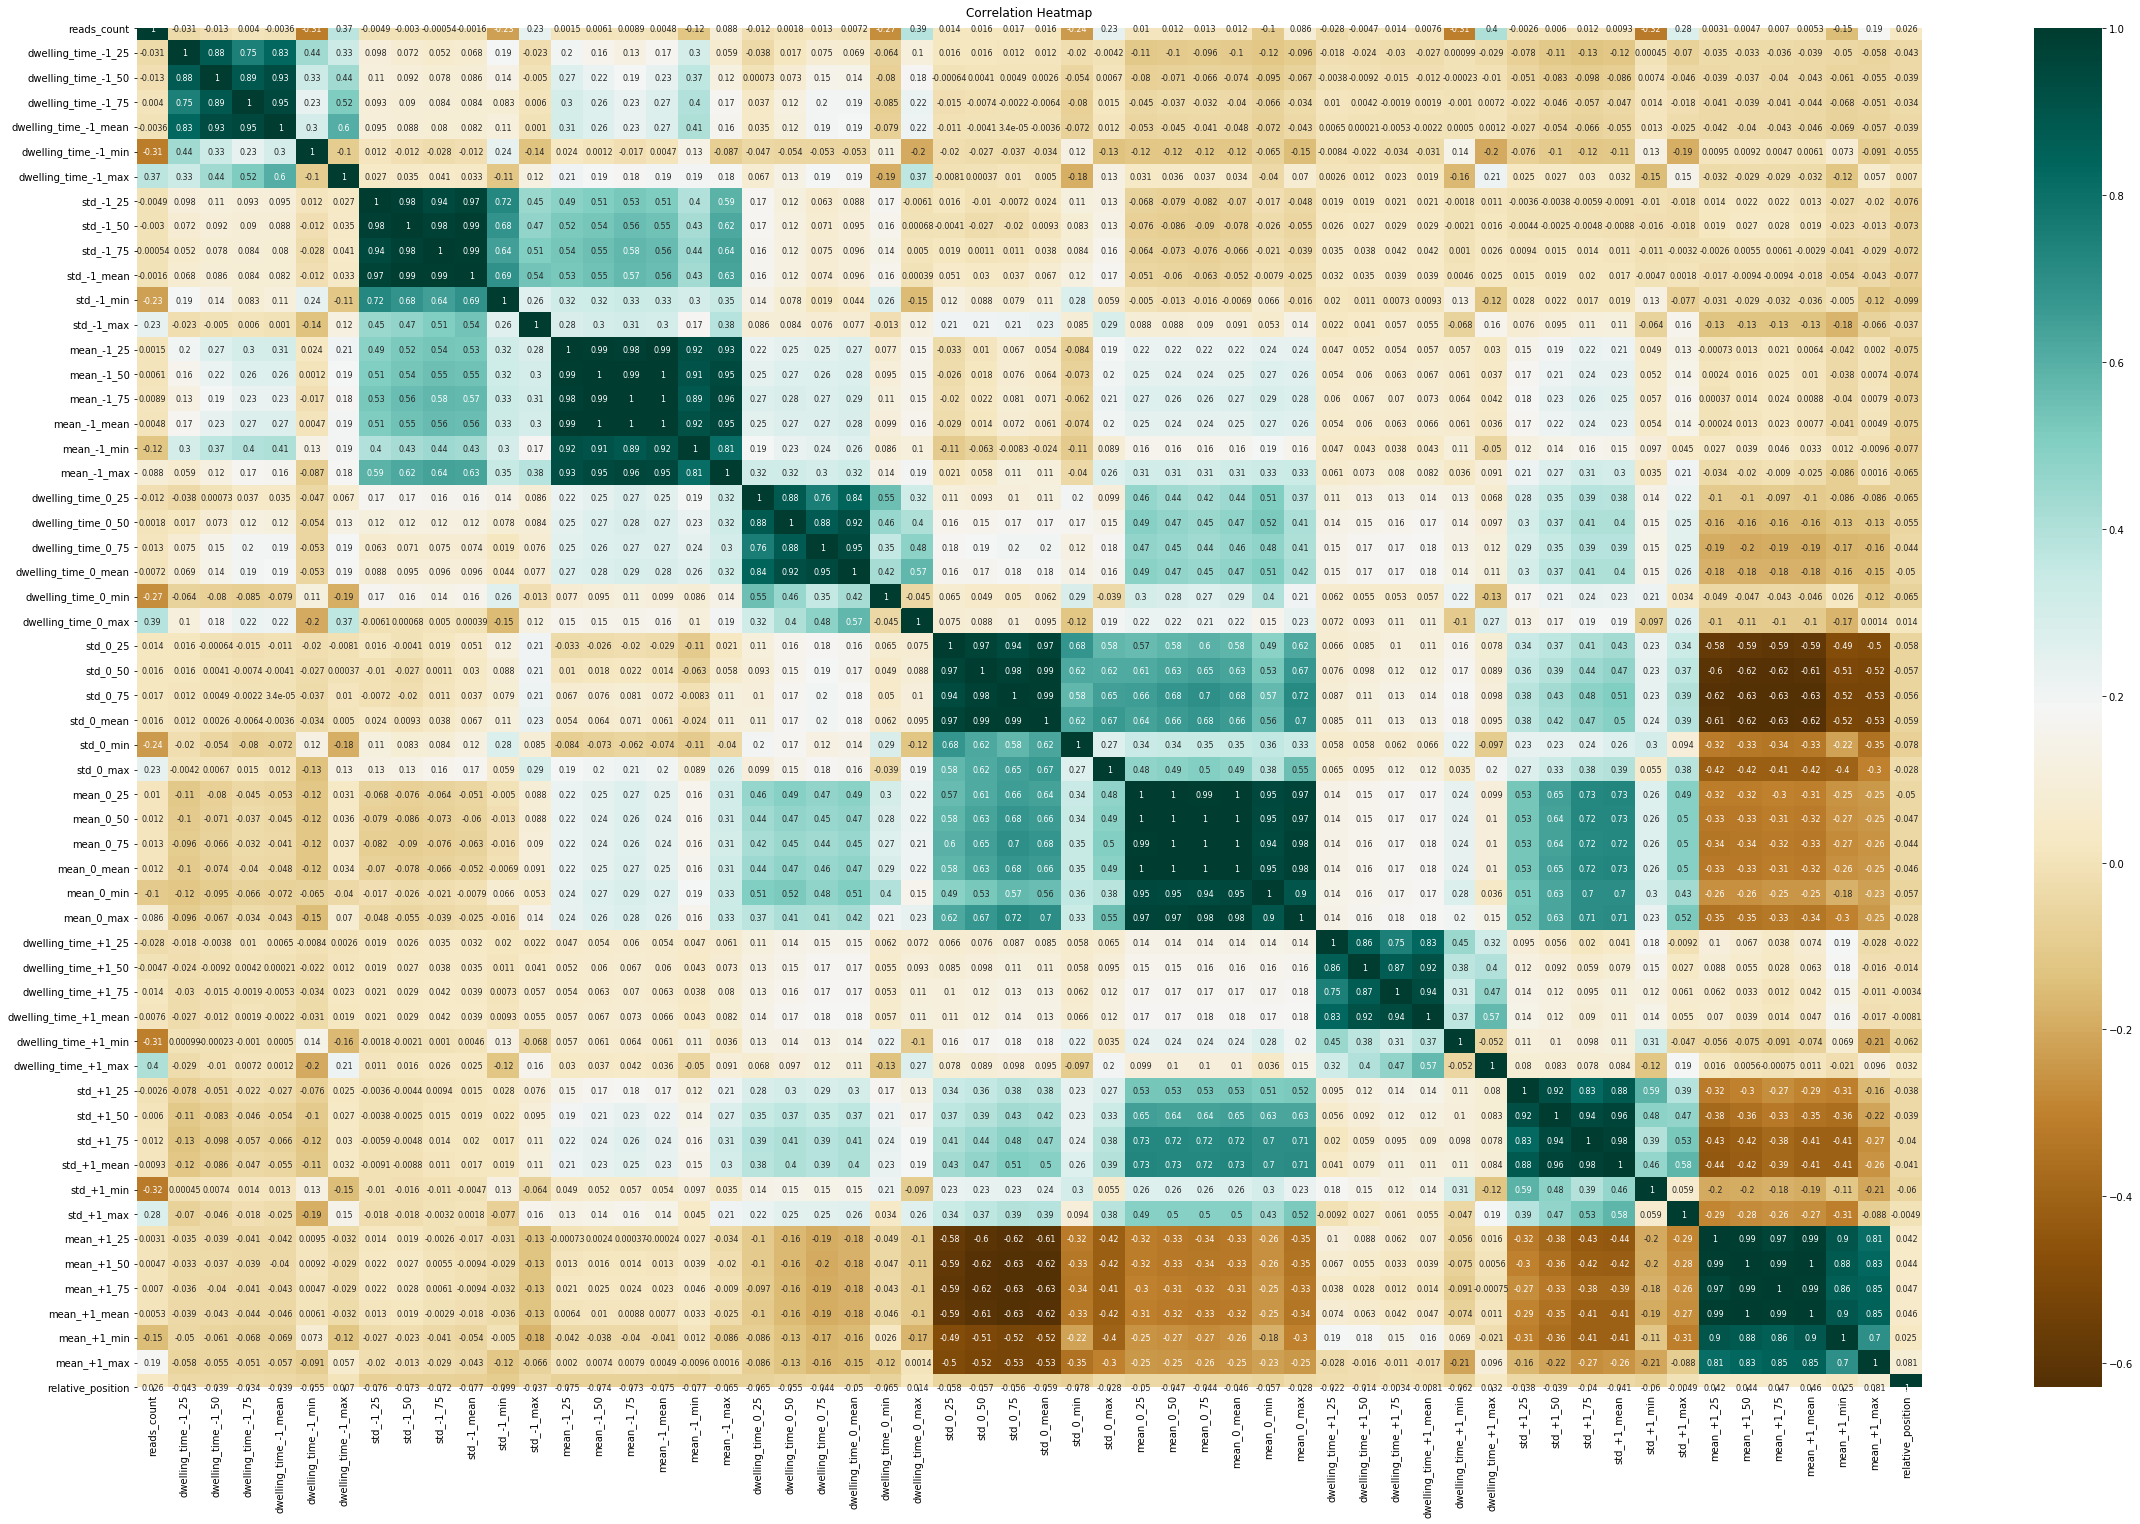

In [9]:
plt.figure(figsize=(40,25))
corrMatrix = num_data.corr()
heatmap = sns.heatmap(corrMatrix, annot=True, annot_kws={"size": 8}, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

## DROP : mean_0_25, mean_0_50, mean_0_75, mean_0_mean, mean_0_min, mean_0_max, mean_+1_25, mean_+1_50, mean_+1_75, mean_-1_mean, mean_+1_min, mean_+1_max, mean_-1_25, mean_-1_50, mean_-1_75, mean_+1_mean, mean_-1_min, mean_-1_max. mean_+1_mean

In [10]:
data = data.drop(['mean_0_25', 'mean_0_50', 'mean_0_75', 'mean_0_mean', 'mean_0_min', 'mean_0_max',
                  'mean_+1_25', 'mean_+1_50', 'mean_+1_75', 'mean_+1_mean', 'mean_+1_min', 'mean_+1_max',
                  'mean_-1_25', 'mean_-1_50', 'mean_-1_75','mean_-1_mean',  'mean_-1_min', 'mean_-1_max'  ], axis=1)
                  
num_data = num_data.drop(['mean_0_25', 'mean_0_50', 'mean_0_75', 'mean_0_mean', 'mean_0_min', 'mean_0_max',
                  'mean_+1_25', 'mean_+1_50', 'mean_+1_75', 'mean_+1_mean', 'mean_+1_min', 'mean_+1_max',
                  'mean_-1_25', 'mean_-1_50', 'mean_-1_75','mean_-1_mean',  'mean_-1_min', 'mean_-1_max'], axis=1)

# Relationships between Numerical Variables and Response Variable: Label

C:\Users\Zoe\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Zoe\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Zoe\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


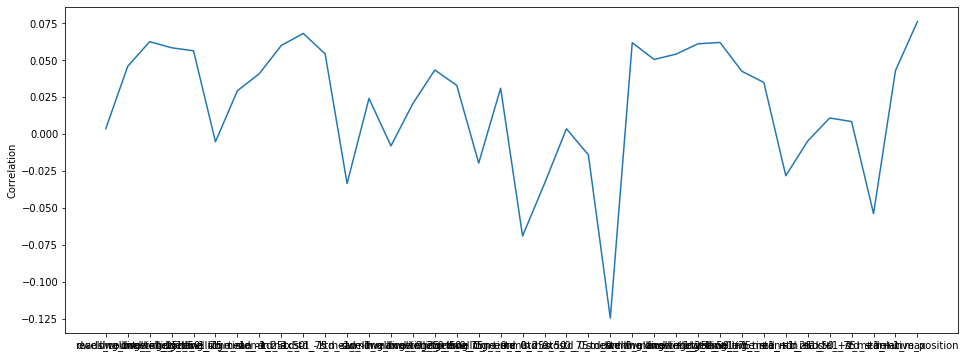

In [16]:
#CREATING A TABLE OF BISERIAL CORRELATIONS BETWEEN LABEL AND NUMERICAL VARIABLES
lst1=[]
lst2=[]
for i in range(len(num_data.columns)):
    col_name = num_data.columns[i]
    value = pointbiserialr(cat_data.label.to_numpy(), num_data[col_name].to_numpy())
    lst1.append(value[0])
    lst2.append(value[1])

biserial_corr = pd.DataFrame({"Correlation": lst1, "P-Value": lst2}, index = num_data.columns)

plt.figure(figsize=(16,6))
sns.lineplot(x=biserial_corr.index, y=biserial_corr.Correlation)

There are no variables that has p-value > 0.05 for their correlation ==> all is good

# Removing from data

In [21]:
X_train_dropped = X_train.drop(['mean_0_25', 'mean_0_50', 'mean_0_75', 'mean_0_mean', 'mean_0_min', 'mean_0_max',
                  'mean_+1_25', 'mean_+1_50', 'mean_+1_75', 'mean_+1_mean', 'mean_+1_min', 'mean_+1_max',
                  'mean_-1_25', 'mean_-1_50', 'mean_-1_75','mean_-1_mean',  'mean_-1_min', 'mean_-1_max'  ], axis=1)
                  
X_test_dropped = X_test.drop(['mean_0_25', 'mean_0_50', 'mean_0_75', 'mean_0_mean', 'mean_0_min', 'mean_0_max',
                  'mean_+1_25', 'mean_+1_50', 'mean_+1_75', 'mean_+1_mean', 'mean_+1_min', 'mean_+1_max',
                  'mean_-1_25', 'mean_-1_50', 'mean_-1_75','mean_-1_mean',  'mean_-1_min', 'mean_-1_max'], axis=1)

X_val_dropped = X_val.drop(['mean_0_25', 'mean_0_50', 'mean_0_75', 'mean_0_mean', 'mean_0_min', 'mean_0_max',
                  'mean_+1_25', 'mean_+1_50', 'mean_+1_75', 'mean_+1_mean', 'mean_+1_min', 'mean_+1_max',
                  'mean_-1_25', 'mean_-1_50', 'mean_-1_75','mean_-1_mean',  'mean_-1_min', 'mean_-1_max'], axis=1)

# Feature Importance with Logistic Regression

C:\Users\Zoe\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Zoe\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Feature: 0, Score: -0.01225
Feature: 1, Score: 0.06817
Feature: 2, Score: 0.24594
Feature: 3, Score: -0.01801
Feature: 4, Score: -0.21914
Feature: 5, Score: 0.06307
Feature: 6, Score: -0.03768
Feature: 7, Score: -0.63531
Feature: 8, Score: 0.10561
Feature: 9, Score: 0.71908
Feature: 10, Score: 0.11484
Feature: 11, Score: -0.18175
Feature: 12, Score: -0.00640
Feature: 13, Score: -0.29946
Feature: 14, Score: -0.05739
Feature: 15, Score: 0.13809
Feature: 16, Score: 0.03062
Feature: 17, Score: -0.05195
Feature: 18, Score: -0.06817
Feature: 19, Score: -0.87244
Feature: 20, Score: -0.65435
Feature: 21, Score: 0.11778
Feature: 22, Score: 0.23495
Feature: 23, Score: -0.19420
Feature: 24, Score: 0.02739
Feature: 25, Score: -0.06108
Feature: 26, Score: -0.11562
Feature: 27, Score: 0.06468
Feature: 28, Score: 0.11061
Feature: 29, Score: 0.00657
Feature: 30, Score: -0.02476
Feature: 31, Score: -0.22766
Feature: 32, Score: 0.39777
Feature: 33, Score: -0.24570
Feature: 34, Score: -0.19662
Feature: 3

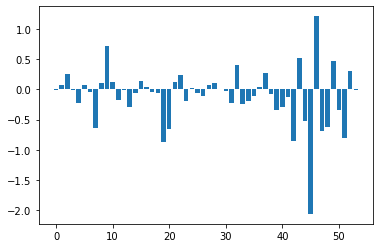

In [22]:
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
# define the model
model = LogisticRegression(random_state=42)
# fit the model
model.fit(X_train_dropped, y_train)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)

pyplot.show()

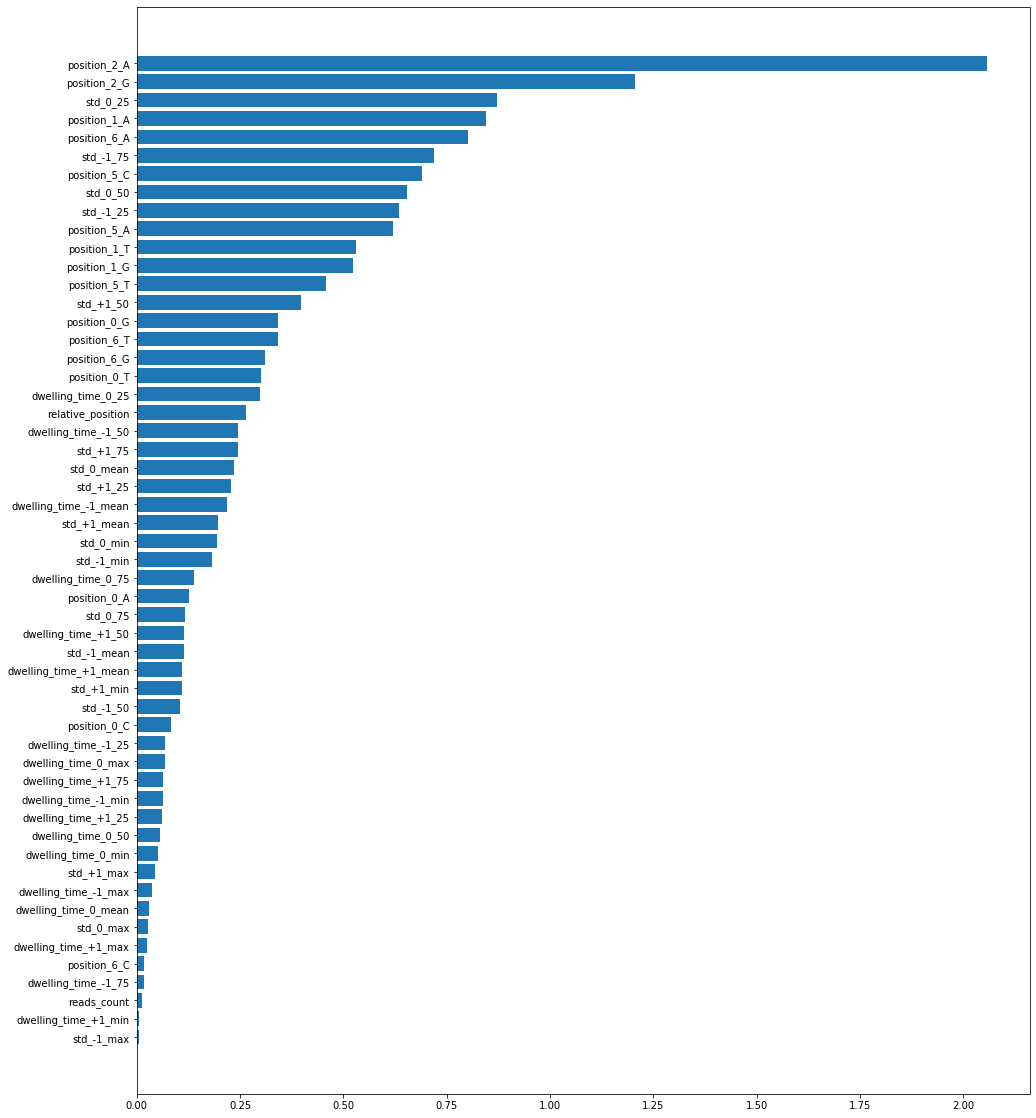

In [26]:
#SORT VALUES ACCORDING TO IMPORTANCE SCORE AND OUTPUT FEATURE IMPORTANCE BAR CHART BY VARIABLE (SORTED)
sorted_imp = list(np.argsort(np.abs(importance)))
plt.figure(figsize=(16,20))
plt.barh(X_train_dropped.columns[sorted_imp], np.abs(importance)[sorted_imp])
imp_logreg = pd.DataFrame(data = {"Feature": X_train_dropped.columns[sorted_imp], "Importance Score": np.abs(importance)[sorted_imp]})

# Feature Importance with Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
# fit the model
model.fit(X_train_dropped, y_train)

C:\Users\Zoe\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(random_state=42)

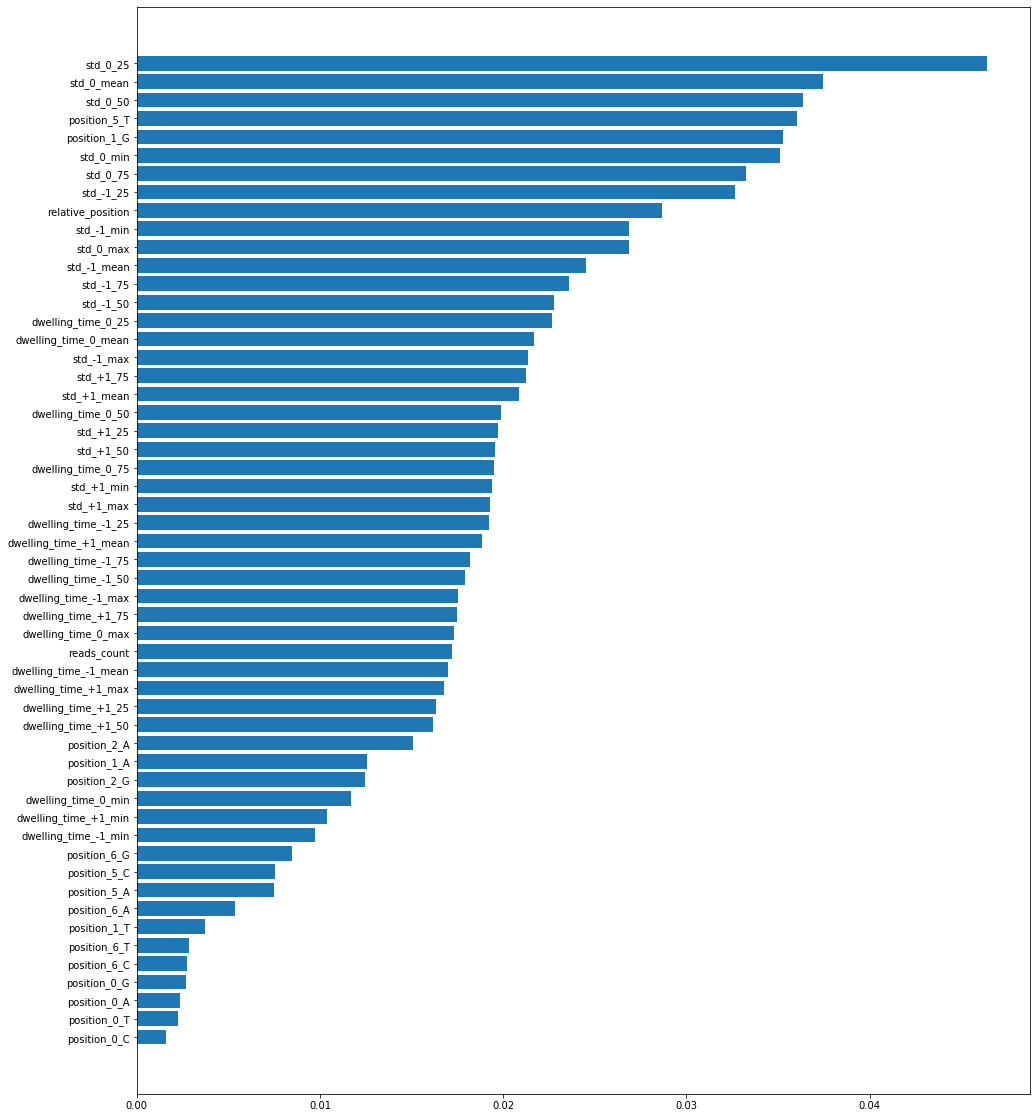

In [30]:
#SORT VALUES ACCORDING TO IMPORTANCE SCORE AND OUTPUT FEATURE IMPORTANCE BAR CHART BY VARIABLE (SORTED)
sorted = model.feature_importances_.argsort()
plt.figure(figsize=(16,20))
plt.barh(X_train_dropped.columns[sorted], model.feature_importances_[sorted])
imp_rf = pd.DataFrame(data = {"Feature": X_train_dropped.columns[sorted], "Importance Score": model.feature_importances_[sorted]})